In [2]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

import pandas as pd

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

## Earth-Sun distances

In [3]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel('Data/Earth-Sun_distances.xlsx')


ES_distances = jnp.array(df.iloc[:, 1::2].apply(pd.to_numeric, errors='coerce')\
                                  .stack().reset_index(drop=True).tolist())[:-1]
ES_dists_kpc = ES_distances*Params.AU/Params.kpc

# print(ES_distances[jnp.array([0,-1])])
#? first and last day are the same day? since there are 366 elements?

days = jnp.arange(1,len(ES_distances)+1)

print(ES_distances.shape, days.shape)

print(ES_distances[0], ES_dists_kpc[0])

(365,) (365,)
0.9833098 4.7672204384173685e-09


## Integration steps

In [4]:
from astropy.time import Time
from scipy.integrate import quad

def z_at_age(age):
    # Function to calculate redshift for a given age of the universe
    def age_diff(z):
        return cosmo.age(z).to(apu.year).value - age
    
    # Use root_scalar to find the redshift that gives the specified age
    sol = root_scalar(age_diff, bracket=[0, 10], method='brentq', xtol=1e-12, rtol=1e-12)
    return sol.root

def get_redshift_array():
    # Today's date
    today = Time.now()
    
    days = 365

    # Initialize an array to store redshift values with 64-bit precision
    redshifts = jnp.zeros(days, dtype=jnp.float64)
    
    # Age of the universe today
    age_today = cosmo.age(0).to(apu.year).value
    
    # Calculate redshift for each day in the past year
    for day in range(days):
        # Calculate the date for each day of the past year
        past_date = today - day * apu.day
        # Calculate the lookback time in years
        lookback_time = (today - past_date).to(apu.year).value
        # Calculate the age of the universe at this lookback time
        age_of_universe_then = age_today - lookback_time
        # Find the redshift corresponding to this age of the universe
        redshift = z_at_age(age_of_universe_then)
        # Store the redshift value in the array
        redshifts = redshifts.at[day].set(redshift)
    
    return redshifts


def s_of_z(z, args):
    """
    Convert redshift to time variable s with eqn. 4.1 in Mertsch et al.
    (2020), keeping only Omega_M and Omega_L in the Hubble eqn. for H(z).

    Args:
        z (float): redshift

    Returns:
        float: time variable s (in [seconds] if 1/H0 factor is included)
    """    

    def s_integrand(z):        

        # We need value of H0 in units of 1/s.
        H0_val = args.H0/(1/args.s)
        a_dot = np.sqrt(args.Omega_M*(1.+z)**3 + args.Omega_L)/(1.+z)*H0_val
        s_int = 1./a_dot

        return s_int

    s_of_z, _ = quad(s_integrand, 0., z)

    return jnp.float64(s_of_z)


# Get the redshift array for the past year
z_int_steps_1year = get_redshift_array()
print(z_int_steps_1year.shape)

s_int_steps_1year = jnp.array([s_of_z(z, Params()) for z in z_int_steps_1year])
print(s_int_steps_1year.min(), s_int_steps_1year[2], s_int_steps_1year.max())
for i in range(5):
    dt0 = (s_int_steps_1year[i+2]+s_int_steps_1year[i+1])/10_000
    print(dt0)

jnp.save(f"{sim_folder}/z_int_steps_1year.npy", z_int_steps_1year)
jnp.save(f"{sim_folder}/s_int_steps_1year.npy", s_int_steps_1year)

(365,)
0.0 228198.6916895429 31473127.19234888
22.81986916895429
48.757589759985635
60.52438450327157
77.81910398293357
95.11437842804608


## Mini sim

In [9]:
from Shared.specific_CNB_sim import *
import pandas as pd

total_start = time.perf_counter()

@jax.jit
def EOMs_sun(s_val, y, args):

    # Unpack the input data
    s_int_steps, z_int_steps, kpc, s = args

    # Initialize vector.
    x_i, u_i = y

    # Switch to "numerical reality" here.
    x_i *= kpc
    u_i *= (kpc/s)

    # Find z corresponding to s via interpolation.
    z = Utils.jax_interpolate(s_val, s_int_steps, z_int_steps)

    # Compute gradient of sun.
    # grad_sun = SimExec.sun_gravity(x_i, jnp.array([0.,0.,0.]))

    grad_sun = jnp.array([0., 0., 0.])


    # Switch to "physical reality" here.
    grad_sun /= (kpc/s**2)
    x_i /= kpc
    u_i /= (kpc/s)


    # Hamilton eqns. for integration (global minus, s.t. we go back in time).
    dyds = -jnp.array([
        u_i, 1./(1.+z)**2 * grad_sun
    ])

    return dyds


def save_to_file(data, filename):
    np.savetxt(filename, data, fmt='%s')


@jax.jit
def compute_trajectory(init_vector, s_int_steps, z_int_steps, kpc, s):
    """
    Core computation function to be JIT compiled. This function performs the ODE solving without error handling.
    """
    # Initial vector in correct shape for EOMs function
    y0 = init_vector.reshape(2, 3)

    # ODE solver setup
    term = diffrax.ODETerm(EOMs_sun)
    t0 = s_int_steps[0]
    t1 = s_int_steps[-1]
    dt0 = (s_int_steps[4] - s_int_steps[3]) / 10  # Adjusting initial step size

    solver = diffrax.Dopri5()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)

    saveat = diffrax.SaveAt(ts=jnp.array(s_int_steps))
    max_steps = 10_000

    sol = diffrax.diffeqsolve(
        term, solver,
        t0=t0, t1=t1, dt0=dt0, y0=y0, max_steps=max_steps,
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=(s_int_steps, z_int_steps, kpc, s), throw=False)

    trajectory = sol.ys.reshape(len(s_int_steps), 6)

    return sol, jnp.stack([trajectory[0], trajectory[-1]])


def backtrack_1_neutrino(init_vector, s_int_steps, z_int_steps, kpc, s, day, pixel, directory):
    try:
        sol, result = compute_trajectory(init_vector, s_int_steps, z_int_steps, kpc, s)
        return result
    except Exception as e:
        print("Solver failed to converge within the max steps limit.")

        ts_filename = os.path.join(
            directory, f"sol_ts_day{day}_pixel{pixel}.txt")
        stats_filename = os.path.join(
            directory, f"sol_stats_day{day}_pixel{pixel}.txt")

        save_to_file(sol.ts, ts_filename)
        save_to_file(sol.stats, stats_filename)

        raise e
    

def simulate_neutrinos_1_pix(init_xyz, init_vels, common_args, day, directory):
    nus = init_vels.shape[0]
    init_vectors = jnp.array(
        [jnp.concatenate((init_xyz, init_vels[k])) for k in range(nus)]
    )

    trajectories = jnp.array([
        backtrack_1_neutrino(vec, *common_args, day=day, pixel=k, directory=directory) 
        for k, vec in enumerate(init_vectors)])

    return trajectories  # shape = (nus, 2, 3)



# Integration steps and massrange
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')
nu_massrange = jnp.load(f'{sim_folder}/neutrino_massrange_eV.npy')*Params.eV

# Earth distances from file, and days array
df = pd.read_excel('Data/Earth-Sun_distances.xlsx')
ES_distances = jnp.array(
    df.iloc[:, 1::2].apply(pd.to_numeric, errors='coerce').stack().reset_index(drop=True).tolist())[:-1]
days = jnp.arange(1,len(ES_distances)+1)

# Lists for pixel and total number densities
pix_dens_l = []
tot_dens_l = []

for day, ES_dist in zip(days[:1], ES_distances[:1]):

    init_xyz = jnp.array([ES_dist*Params.AU/Params.kpc, 0., 0.])

    if day == days[0]:
        print(init_xyz)
        print(s_int_steps[0], s_int_steps[-1])
        print(z_int_steps[0], z_int_steps[-1])

    print(f"*** Simulation for day={day}/{len(days)} ***")


    ### ============== ###
    ### Run Simulation ###
    ### ============== ###

    sim_start = time.perf_counter()

    with open(f'{sim_folder}/sim_parameters.yaml', 'r') as file:
        sim_setup = yaml.safe_load(file)

    # Size (in sr) of all-sky healpixels
    pix_sr_sim = sim_setup['pix_sr']

    # Number of healpixels 
    Npix = sim_setup["Npix"]

    # Number of neutrinos per healpixel
    nu_per_pix = sim_setup["momentum_num"]

    #TODO: this should be changing each day as Earth orientation changes w.r.t.
    #TODO: phase-space results from main sim
    init_vels = np.load(f'{sim_folder}/initial_velocities.npy')[:,100:200,:]
    # shape = (Npix, neutrinos per pixel, 3)

    # Common arguments for simulation
    common_args = (s_int_steps, z_int_steps, Params.kpc, Params.s)

    # Use ProcessPoolExecutor to distribute the simulations across processes
    with ProcessPoolExecutor(1) as executor:
        futures = [
            executor.submit(
                simulate_neutrinos_1_pix, init_xyz, init_vels[pixel], common_args, day, sim_folder) for pixel in range(2)
        ]

        # Wait for all futures to complete and collect results in order
        nu_vectors = jnp.array([future.result() for future in futures])

    print(nu_vectors.shape)

    """
    # Save all sky neutrino vectors for current halo
    jnp.save(f'{sim_folder}/vectors_day{day}.npy', nu_vectors)
    """
    
    sim_time = time.perf_counter()-sim_start
    print(f"Simulation time: {sim_time/60.:.2f} min, {sim_time/(60**2):.2f} h")


    ### ======================== ###
    ### Compute number densities ###
    ### ======================== ###

    ana_start = time.perf_counter()

    # Compute individual number densities for each healpixel
    nu_allsky_masses = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
    pix_dens = Physics.number_densities_all_sky(
        v_arr=nu_vectors[..., 3:],
        m_arr=nu_allsky_masses,
        pix_sr=pix_sr_sim,
        args=Params())
    pix_dens_l.append(jnp.squeeze(pix_dens))
    
    # Compute total number density, by using all neutrino vectors for integral
    tot_dens = Physics.number_densities_mass_range(
        v_arr=nu_vectors.reshape(-1, 2, 6)[..., 3:], 
        m_arr=nu_massrange, 
        pix_sr=4*Params.Pi,
        args=Params())
    tot_dens_l.append(jnp.squeeze(tot_dens))
    
    ana_time = time.perf_counter() - ana_start
    print(f"Analysis time: {ana_time/60.:.2f} min, {ana_time/(60**2):.2f} h\n")


tot_time = time.perf_counter() - total_start
print(f"Total time: {tot_time/60.:.2f} min, {tot_time/(60**2):.2f} h")

print(jnp.array(pix_dens_l).shape)

[4.76722044e-09 0.00000000e+00 0.00000000e+00]
0.0 31473127.19234888
0.0 6.895992031933051e-11
*** Simulation for day=1/365 ***
(2, 100, 2, 6)
Simulation time: 0.14 min, 0.00 h
Analysis time: 0.00 min, 0.00 h

Total time: 0.15 min, 0.00 h
(1, 5, 2)


In [10]:
print(jnp.array(pix_dens_l))

[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


## No gravity

In [21]:
@jax.jit
def EOMs_no_gravity(s_val, y, args):

    # Initialize vector.
    _, u_i = y

    # Hamilton eqns. for integration (global minus, s.t. we go back in time).
    dyds = -jnp.array([
        u_i, jnp.zeros(3)
    ])

    return dyds


@jax.jit
def backtrack_1_neutrino(init_vector, s_int_steps):

    """
    Simulate trajectory of 1 neutrino. Input is 6-dim. vector containing starting positions and velocities of neutrino. Solves ODEs given by the EOMs function with an jax-accelerated integration routine, using the diffrax library. Output are the positions and velocities at each timestep, which was specified with diffrax.SaveAt. 
    """

    # Initial vector in correct shape for EOMs function
    y0 = init_vector.reshape(2,3)

    # ODE solver setup
    term = diffrax.ODETerm(EOMs_no_gravity)
    t0 = s_int_steps[0]
    t1 = s_int_steps[-1]
    dt0 = (s_int_steps[0] + s_int_steps[1]) / 1000
    

    ### ------------- ###
    ### Dopri5 Solver ###
    ### ------------- ###
    solver = diffrax.Dopri5()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)


    # Specify timesteps where solutions should be saved
    saveat = diffrax.SaveAt(ts=jnp.array(s_int_steps))
    
    # Solve the coupled ODEs, i.e. the EOMs of the neutrino
    sol = diffrax.diffeqsolve(
        term, solver, 
        t0=t0, t1=t1, dt0=dt0, y0=y0, max_steps=10000,
        saveat=saveat, stepsize_controller=stepsize_controller, args=None)
    
    trajectory = sol.ys.reshape(s_int_steps.shape[0],6)

    # Only return the initial [0] and last [-1] positions and velocities
    return jnp.stack([trajectory[0], trajectory[-1]])


def simulate_neutrinos_1_pix(init_xyz, init_vels, s_int_steps):

    """
    Function for the multiprocessing routine below, which simulates all neutrinos for 1 pixel on the healpix skymap.
    """

    # Neutrinos per pixel
    nus = init_vels.shape[0]

    # Make vector with same starting position but different velocities
    init_vectors = jnp.array(
        [jnp.concatenate((init_xyz, init_vels[k])) for k in range(nus)])


    trajectories = jnp.array([
        backtrack_1_neutrino(vec, s_int_steps) for vec in init_vectors])
    
    return trajectories  # shape = (neutrinos, 2, 6)


# Integration steps and massrange
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps.npy')
nu_massrange = jnp.load(f'{sim_folder}/neutrino_massrange_eV.npy')*Params.eV


# Lists for pixel and total number densities
pix_dens_l = []
tot_dens_l = []

# File name ending
end_str = f'halo1'

# Initial position (Earth)
init_xyz = np.array([8.5, 0., 0.])

### ============== ###
### Run Simulation ###
### ============== ###

print(f"*** Simulation for no_gravity ***")

sim_start = time.perf_counter()

with open(f'{sim_folder}/sim_parameters.yaml', 'r') as file:
    sim_setup = yaml.safe_load(file)

pix_sr_sim = sim_setup['pix_sr']        # Size (in sr) of all-sky healpixels
Npix = sim_setup["Npix"]                # Number of healpixels 
nu_per_pix = sim_setup["momentum_num"]  # Number of neutrinos per healpixel

init_vels = np.load(f'{sim_folder}/initial_velocities.npy')[:,:100,:]
# shape = (Npix, neutrinos per pixel, 3)


# Use ProcessPoolExecutor to distribute the simulations across processes:
# 1 process (i.e. CPU) simulates all neutrinos for one healpixel.
with ProcessPoolExecutor(2) as executor:
    futures = [
        executor.submit(
            simulate_neutrinos_1_pix, init_xyz, init_vels[pixel], s_int_steps) for pixel in range(Npix)]
    
    # Wait for all futures to complete and collect results in order
    nu_vectors = jnp.array([future.result() for future in futures])


# Save all sky neutrino vectors for current halo
# jnp.save(f'{sim_folder}/vectors_{end_str}.npy', nu_vectors)

sim_time = time.perf_counter()-sim_start
print(f"Simulation time: {sim_time/60.:.2f} min, {sim_time/(60**2):.2f} h")


### ======================== ###
### Compute number densities ###
### ======================== ###


# Compute individual number densities for each healpixel
pix_start = time.perf_counter()

nu_allsky_masses = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
pix_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_allsky_masses,
    pix_sr=pix_sr_sim,
    args=Params())
pix_dens_l.append(jnp.squeeze(pix_dens))

pix_time = time.perf_counter() - pix_start

# jnp.save(f"{sim_folder}/pixel_densities.npy", jnp.array(pix_dens_l))
print(f"Analysis time: {pix_time/60.:.2f} min, {pix_time/(60**2):.2f} h\n")


# Compute total number density, by using all neutrino vectors for integral
tot_start = time.perf_counter()

tot_dens = Physics.number_densities_mass_range(
    v_arr=nu_vectors.reshape(-1, 2, 6)[..., 3:], 
    m_arr=nu_massrange, 
    pix_sr=4*Params.Pi,
    args=Params())
tot_dens_l.append(jnp.squeeze(tot_dens))

tot_time = time.perf_counter() - tot_start

# jnp.save(f"{sim_folder}/total_densities.npy", jnp.array(tot_dens_l))
print(f"Analysis time: {tot_time/60.:.2f} min, {tot_time/(60**2):.2f} h\n")


total_time = time.perf_counter() - total_start
print(f"Total time: {total_time/60.:.2f} min, {total_time/(60**2):.2f} h")

test = jnp.array(tot_dens_l)[0]/Params.cm**-3
print(f"{test[0]:.2f}")

*** Simulation for no_gravity ***
Simulation time: 0.36 min, 0.01 h
Analysis time: 0.00 min, 0.00 h

Analysis time: 0.02 min, 0.00 h

Total time: 11.32 min, 0.19 h


In [24]:
test = jnp.array(tot_dens_l)[0]
print(f"{test[0]:.9f}")

0.000000004


## Plot outputs

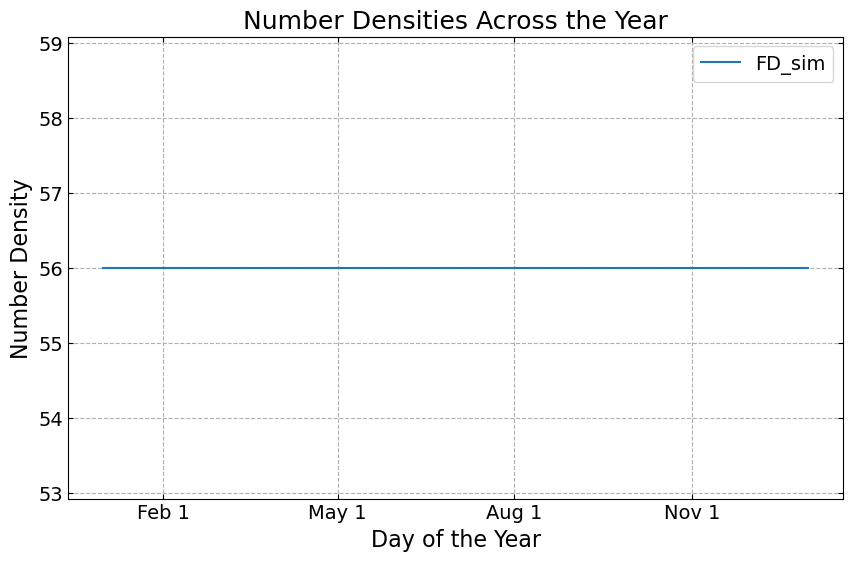

In [6]:
def modulation(nu_dens_days=None):
    # Example data (replace with your actual data)
    days = jnp.arange(1, 366)  # 1 to 365 for each day of the year
    
    if nu_dens_days is None:
        nu_dens_days = jnp.ones_like(days)*56  # Example number densities for each day (replace with your data)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, nu_dens_days, label='FD_sim')

    # Customize x-axis to show ticks and labels only on specific dates
    tick_days = [305, 32, 122, 213]  # Corresponding to Nov 1, Feb 1, May 1, and Aug 1
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Add labels and title
    plt.xlabel('Day of the Year')
    plt.ylabel('Number Density')
    plt.title('Number Densities Across the Year')
    plt.legend()

    # Show grid for better readability
    plt.grid(True, which="major", linestyle="dashed")

    # Display the plot
    plt.show()

modulation()